In [1]:
from simpeggpr import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')
# matplotlib.rcParams['savefig.dpi'] = 100 # Change this to adjust figure size

In [3]:
cs =  1.5*1e-1
hx = np.ones(500)*cs
hy = np.ones(200)*cs
mesh = Mesh.TensorMesh([hx, hy], 'CC')
epsilon = epsilon_0*np.ones(mesh.nC)*1.
epsilon[mesh.gridCC[:,1]<10.] = epsilon_0*8.
epsilon[mesh.gridCC[:,1]<5.] = epsilon_0*2.

(<matplotlib.collections.QuadMesh at 0x10589d510>,)

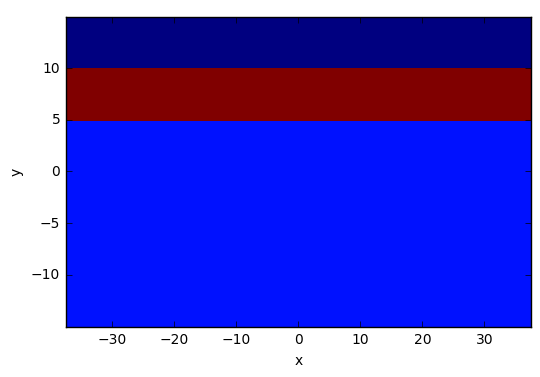

In [4]:
mesh.plotImage(epsilon)

In [5]:
dt = 2.0e-10
fmain = 1e8
time = np.arange(1500)*dt
options={'tlag':2./fmain, 'fmain':fmain}
x_rx = np.arange(101)*0.3+0.3
rx = GPRTEzRx(np.c_[x_rx, 10.*np.ones(x_rx.size)], 'Ex')
tx = GPRTEzSrc(np.r_[0, 10.], time, [rx], srcType='Mz', **options)
survey = SurveyGPRTime([tx])
wave = tx.RickerWavelet()
prob = GPR2DTEzProblemPML(mesh)
prob.pair(survey)
mu = mu_0*np.ones(mesh.nC)
sighalf = 0.
sig0 = sighalf*np.ones(mesh.nC)
prob.setPMLBC(15, dt)
prob.sm = 3.
prob.stabilitycheck(epsilon, mu, sig0, time, fmain, sigs=0.)
storefield = True

You are good to go:)
>> Stability information
   dt: 2.00e-10 s
   Optimal dt: 2.50e-10 s
   Cell per wavelength (G): 7.07e+00
   Optimal G: 1.20e+00
>> sm: 3.00e+00, lamda: 1.06e+00, sigm: 6.67e-02


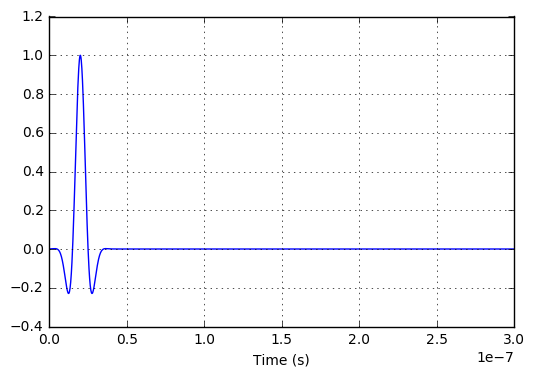

In [6]:
plt.plot(time, tx.wave)
plt.xlabel('Time (s)')
plt.grid(True)

In [7]:
Fields = prob.fields(epsilon, mu, sig0)


***** Start Computing Electromagnetic Wave *****

>> dt: 2.00e-10 s
>> Optimal dt: 2.50e-10 s
>> Main frequency, fmain: 1.00e+08 Hz
>> Cell per wavelength (G): 7.07e+00
  Src at (   0.00,    0.00):    1/   1
>>Elapsed time: 5.38e+01 s


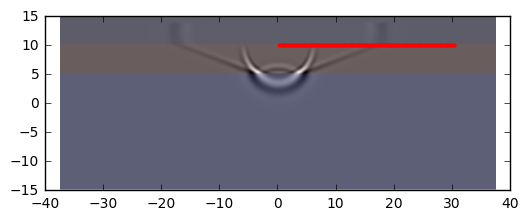

In [30]:
icount = 400
extent = [mesh.vectorCCx.min(), mesh.vectorCCx.max(), mesh.vectorCCy.min(), mesh.vectorCCy.max()]
plt.imshow(np.flipud(Fields['H', tx][:,icount].reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'gray', extent=extent)
dat = plt.imshow(np.flipud(epsilon.reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'jet', alpha = 0.1, extent=extent )
plt.plot(rx.locs[:,0], rx.locs[:,1], 'r.', ms = 5)
# plt.colorbar(dat)
plt.show()

In [9]:
# from simpegseis import UtilsSeis

In [10]:
data = survey.projectFields(Fields)

In [11]:
def PrimaryWave(tintercept, time, velocity):
    return velocity*time + tintercept

In [12]:
from SimPEG.Utils import sdiag
noise = np.random.randn(data[tx, rx].shape[0],data[tx, rx].shape[1])*0.1
data_temp = sdiag(x_rx**0.5)*data[tx, rx] *sdiag(time**0.)
# data_temp = data_temp/data_temp.max()+noise
data_temp = data_temp/data_temp.max()

In [13]:
np.save('shot_raypaths', data_temp)
np.save('time', time)

In [24]:
# fig = plt.figure()
# kwargs = {
#     'skipt':1,
#     'scale': 0.5,
#     'lwidth': 0.1,
#     'sampr': dt*1e9,
#     'dx': 0.4
# }
# extent = [-1, 40, 300, 0]
# fig, ax1 = plt.subplots(1,1, figsize = (8,5))
# ax1.invert_yaxis()
# ax1.axis(extent)
# UtilsSeis.wiggle(data_temp, **kwargs)
# # ax1.plot(PrimaryWave(0., time, 1/np.sqrt(epsilon_0*mu_0)), time, 'r--', lw=2)

# ax1.set_xlabel('Channel')
# ax1.set_ylabel('Time (ns)')
# ax1.set_title('Shot Gather')
# fig.tight_layout()
# fig.savefig('shotgather.png', dpi = 200)

In [26]:
# from JSAnimation import IPython_display
# from matplotlib import animation
# extent = [mesh.vectorCCx.min(), mesh.vectorCCx.max(), mesh.vectorCCy.min()-10., mesh.vectorCCy.max()-10.]
# fig, ax = plt.subplots(1,1, figsize = (12, 8))
# ax.set_xlabel('x (m)', fontsize = 16)
# ax.set_ylabel('y (m)', fontsize = 16)
# ax.set_xlim(extent[:2])
# ax.set_ylim(extent[2:])
# ax.text(0., 1, 'Tx', fontsize=20)
# ax.text(30., 1., 'Rx', color='r', fontsize=20)
# ax.text(-30., 1., 'Air layer, $\epsilon_r$=1', color='k', fontsize=20)
# ax.text(-30., -3.2, 'Layer 1, $\epsilon_r$=?', color='k', fontsize=20)
# ax.text(-30., -10, 'Layer 2, $\epsilon_r$=?', color='k', fontsize=20)


# nskip = 60
# def animate(i_id):
#     icount = i_id*nskip
#     frame = ax.imshow(np.flipud(Fields['H', tx][:,icount].reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'gray', extent=extent)
    
#     ax.imshow(np.flipud(epsilon.reshape((mesh.nCx, mesh.nCy), order = 'F').T), cmap = 'jet', alpha = 0.1, extent=extent )
#     rxframe = ax.plot(rx.locs[:,0], rx.locs[:,1]-10., 'r.', ms = 10)
#     ax.set_title(('Time = %10.1f ns')%(time[i_id*nskip]*1e9), fontsize = 16)
#     ax.get_xaxis().set_visible(False)
#     ax.get_yaxis().set_visible(False)
#     return frame, rxframe
# animation.FuncAnimation(fig, animate, frames=20, interval=40, blit=True)